# Compare INALT20 and observation along 23$^{\circ}$W

## Tech preample

In [1]:
%matplotlib inline
import os
import seawater as sw
import dask
import cmocean
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from pathlib import Path
from scipy.io import loadmat
# from xorca.lib import load_xorca_dataset
# from xorca_lonlat2ij import get_ij

## Dask jobqueue and client
To controle the resources used for parallel computations on computing nodes.

In [2]:
# import dask_jobqueue
# cluster = dask_jobqueue.SLURMCluster(
#     # Dask worker size
#     cores=4, memory='24GB',
#     processes=1, # Dask workers per job
#     # SLURM job script things
#     queue='cluster', walltime='01:30:00',
#     # Dask worker network and temporary storage
#     interface='ib0', local_directory='$TMPDIR',
#     log_directory='./slurm_logs'
# )

In [3]:
from dask.distributed import Client

In [4]:
# client = Client(cluster)
client = Client(n_workers=1, threads_per_worker=8, memory_limit=12e9)
client

/gxfs_work/geomar/smomw294/.conda/envs/INALT_wind_forcing/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34357 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:37133 Dashboard: http://127.0.0.1:34357/status,Cluster Workers: 1 Cores: 8 Memory: 12.00 GB


In [5]:
# cluster.adapt(
#     minimum=1, maximum=20,
#     target_duration="120s"
# )

## Output parameters

In [6]:
out_dir_data = Path('../data/INALT20_obs_23w_comparison/')
Path(out_dir_data).mkdir(parents=True, exist_ok=True)

In [7]:
out_dir_fig = Path('../figures/INALT20_obs_23w_comparison/')
Path(out_dir_fig).mkdir(parents=True, exist_ok=True)
out_fig_1 = 'INALT20_obs_23w_1999_2012'
out_fig_2 = 'INALT20_obs_23w_2002_2018'
out_fig_3 = 'INALT20_CORE_JRA_obs_23w_1999_2009'
fig_format = '.png'

## Input parameters
For Observations: mean section along 23$^{\circ}$W 

In [8]:
global_data_path_obs = Path('../data/23W_ship_section/Burmeister_et_al_2021/')
file_name_obs = 'ship_sections_23w_merged_all_mean.mat'

For INALT20 

In [9]:
global_data_path = Path("/sfs/fs1/work-geomar1/smomw044/")
JRA_path = "INALT20.L46-KFS10X"
exp_id = "INALT20.L46-KFS10?"

CORE_path = "shared/INALT20.L46-KFS044-S"
CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
nest_prefix = "1_" # "1_" for high resolution; leave empty for base model

restr_years1 = "199[1-9]"  # restricts to 2010 and 2011
restr_years2 = "200[0-9]"
restr_years3 = "201[0-9]"

# chunk sizes
chu_x = 100 # None means take the full dataset
chu_y = 100
chu_z = 9
chu_t = 12

p_ref = 0 # dbar;

In [10]:
lonlim = [-23.2, 22.8]
latlim = [-6,10]
zlim = [0, 1150]

## integers
xclim1 = 925 # 23.2W
xclim2 = 934 # 22.8W
yclim1 = 1509 # 6S
yclim2 = 1832 # 10N

Find relevant data files for INALT20

In [11]:
JRA_files_U = list(sorted(
    (global_data_path / JRA_path ).glob(
        f"{nest_prefix}{exp_id}{temp_res}{restr_years1}????_{restr_years1}????_grid_U.nc")
))
JRA_files_U.extend(list(sorted(
    (global_data_path / JRA_path ).glob(
        f"{nest_prefix}{exp_id}{temp_res}{restr_years2}????_{restr_years2}????_grid_U.nc")
)))
JRA_files_U.extend(list(sorted(
    (global_data_path / JRA_path ).glob(
        f"{nest_prefix}{exp_id}{temp_res}{restr_years3}????_{restr_years3}????_grid_U.nc")
)))

CORE_files_U = list(sorted(
    (global_data_path / CORE_path ).glob(
        f"{nest_prefix}{CORE_exp_id}{temp_res}{restr_years1}????_{restr_years1}????_grid_U.nc"
    )
))
CORE_files_U.extend(list(sorted(
    (global_data_path / CORE_path ).glob(
        f"{nest_prefix}{CORE_exp_id}{temp_res}{restr_years2}????_{restr_years2}????_grid_U.nc"
    )
)))

JRA_files_T = list(sorted(
    (global_data_path / JRA_path ).glob(
        f"{nest_prefix}{exp_id}{temp_res}{restr_years1}????_{restr_years1}????_grid_T.nc")
))
JRA_files_T.extend(list(sorted(
    (global_data_path / JRA_path ).glob(
        f"{nest_prefix}{exp_id}{temp_res}{restr_years2}????_{restr_years2}????_grid_T.nc")
)))
JRA_files_T.extend(list(sorted(
    (global_data_path / JRA_path ).glob(
        f"{nest_prefix}{exp_id}{temp_res}{restr_years3}????_{restr_years3}????_grid_T.nc")
)))

CORE_files_T = list(sorted(
    (global_data_path / CORE_path ).glob(
        f"{nest_prefix}{CORE_exp_id}{temp_res}{restr_years1}????_{restr_years1}????_grid_T.nc"
    )
))
CORE_files_T.extend(list(sorted(
    (global_data_path / CORE_path ).glob(
        f"{nest_prefix}{CORE_exp_id}{temp_res}{restr_years2}????_{restr_years2}????_grid_T.nc"
    )
)))


aux_files = list(sorted(
    (global_data_path/ JRA_path).glob(f"{nest_prefix}[m,n]*.nc")
))
print(f"Found {len(aux_files)} mesh/mask files, {len(CORE_files_U)} CORE and {len(JRA_files_U)} JRA U files.")

Found 1 mesh/mask files, 19 CORE and 28 JRA U files.


In [12]:
aux_files = list(sorted(
        (global_data_path/ JRA_path).glob(f"{nest_prefix}[m,n]*.nc")
    ))

aux_files

with dask.config.set(scheduler='synchronous'):
    ds_mesh = xr.open_dataset(
            aux_files[0],
            decode_cf=True,
            chunks={"t":chu_t,"z":chu_z, 
                    "y":chu_y,"x":chu_x})

In [13]:
## integers
# xclim1 = 925 # 23.2W
# xclim2 = 934 # 22.8W
# yclim1 = 1509 # 6S
# yclim2 = 1832 # 10N

# ds_mesh.gphiu.sel(x=600,y=slice(yclim1,yclim2)).squeeze().values
# ds_mesh.glamu.sel(y=1700,x=slice(xclim1,xclim2)).squeeze().values

## Functions

### Potential density

In [14]:
def calc_pdens_sw(p_ref,ds):
    
    """ Calculates potential density using the EOS-80 seawater library
    Parameters
    ----------
    pref : int
    reference pressure for potential density calculation
    ds : xr.DataSet containing NEMO3 model output
      ds.deptht  : xr.DataArray (depth in m, positive downwards)
      ds.gphit  : xr.DataArray (latitude grid in degN)
      ds.vosaline  : xr.DataArray (practical salinity(eos 80))
      ds.votemper  : xr.DataArray (potential temp (eos 80))
   
    Returns
    -------
    xr.DataArray
    Data array of potential density calculated using the EOS-80 seawater library [kg/m^3], same dimension as input data arrays
    """
    
    # calculate pressure
    p = xr.apply_ufunc(
    sw.eos80.pres,
    -abs(ds.deptht),ds.gphit,
    dask='parallelized', output_dtypes=[float, ]
    )
    
    # calculate in-situ temperature from potential temperature
    t = xr.apply_ufunc(sw.eos80.temp,
                       ds.vosaline,ds.votemper,p,p_ref,
                       dask = 'parallelized',output_dtypes=[float,])
    
    # compute potential density
    sig = xr.apply_ufunc(sw.eos80.pden,
                         ds.vosaline,t,p,p_ref,
                         dask = 'parallelized',output_dtypes=[float,])
    sig -= 1000
    
    sig['tmask'] = ds.tmask
    sig = sig.where(sig.tmask==1)
    sig.name='sigma_%sm' %p_ref
    sig.attrs['units']='kg/m^3'
    sig.attrs['long_name']='Potential density'
    sig.attrs['reference_pressure']= '%s dbar' %p_ref
    
    return sig

## Open (virtual) model dataset

In [15]:
def load_model_output(JRA_files_T, JRA_files_U,ds_mesh,chu_t,chu_z,chu_y,chu_x,zlim,yclim1,yclim2,xclim1,xclim2):
    ##load output
    with dask.config.set(scheduler='synchronous'):
        ds_JRA_T = xr.open_mfdataset(
            JRA_files_T,
            chunks={"time_counter":chu_t,
                             "deptht":chu_z, 
                             "y":chu_y, 
                             "x":chu_x},
            decode_cf=True,
            )
    ds_JRA_T = ds_JRA_T.get(['vosaline','votemper'])

    with dask.config.set(scheduler='synchronous'):
        ds_JRA_U = xr.open_mfdataset(
        JRA_files_U,
        decode_cf=True,
        chunks={"time_counter":chu_t,
                         "depthu":chu_z, 
                         "y":chu_y, 
                         "x":chu_x})


    ## select region
    ds_JRA_T = ds_JRA_T.assign_coords(gphit=(['y','x'],ds_mesh.gphit.squeeze()))
    ds_JRA_T = ds_JRA_T.assign_coords(glamt=(['y','x'],ds_mesh.glamt.squeeze()))
    ds_JRA_T = ds_JRA_T.drop(['nav_lat','nav_lon'])

    ds_JRA_U = ds_JRA_U.assign_coords(gphiu=(['y','x'],ds_mesh.gphiu.squeeze()))
    ds_JRA_U = ds_JRA_U.assign_coords(glamu=(['y','x'],ds_mesh.glamu.squeeze()))
    ds_JRA_U = ds_JRA_U.drop(['nav_lat','nav_lon'])

    ds_JRA_U['e1u'] = (('y', 'x'), ds_mesh.e1u.squeeze())
    ds_JRA_U['e2u'] = (('y', 'x'), ds_mesh.e2u.squeeze())
    ds_JRA_U['e3u'] = (('depthu','y', 'x'), ds_mesh.e3u_0.squeeze())

    ds_JRA_T.coords['tmask'] = ds_mesh.rename_dims({'z':'deptht'}).tmask.squeeze()
    ds_JRA_T = ds_JRA_T.sel(deptht=slice(0,zlim[1]),
                           x=slice(xclim1,xclim2),
                           y=slice(yclim1,yclim2))

    ds_JRA_U = ds_JRA_U.sel(depthu=slice(0,zlim[1]),
                           x=slice(xclim1,xclim2),
                           y=slice(yclim1,yclim2))
    ds_JRA_U = ds_JRA_U.isel(x=slice(0,-1)
                    ).swap_dims({'depthu':'depth'}
                    ).rename({'depthu':'depth'})

    # calculate density
    pdens_JRA = calc_pdens_sw(p_ref,ds_JRA_T)

    with xr.set_options(keep_attrs=True):
        # average on U-Grid
        pdens_JRA =(pdens_JRA.isel(x=slice(None,-1))+pdens_JRA.isel(x=slice(1,None)))/2
        ds_JRA_T =(ds_JRA_T.isel(x=slice(None,-1))+ds_JRA_T.isel(x=slice(1,None)))/2
        # merge to one dataset
        box_JRA = xr.merge([ds_JRA_U.vozocrtx,
                    ds_JRA_U.e1u,
                    ds_JRA_U.e2u,
                    ds_JRA_U.e3u,
                    pdens_JRA.swap_dims({'deptht':'depth'}).rename({'deptht':'depth'}),
                    ds_JRA_T.votemper.swap_dims({'deptht':'depth'}).rename({'deptht':'depth'}),
                    ds_JRA_T.vosaline.swap_dims({'deptht':'depth'}).rename({'deptht':'depth'}),
                    ])

    ## set coordinates and attributes
    lon = box_JRA.glamu.isel(y=5)
    box_JRA = box_JRA.assign_coords(lon=('x',lon))
    lat = box_JRA.gphit.isel(x=0)
    box_JRA = box_JRA.assign_coords(lat=('y',lat))
    box_JRA = box_JRA.swap_dims({'x':'lon','y':'lat'}
                     ).drop({'gphiu','gphit','glamu','time_centered'})
    box_JRA.lat.attrs['units']='°N'
    box_JRA.lat.attrs['long_name']='Latitude'
    box_JRA.lon.attrs['units']='°E'
    box_JRA.lon.attrs['long_name']='Longitude'
    box_JRA.depth.attrs['units']='m'
    box_JRA.depth.attrs['long_name']='Depth'
    box_JRA.attrs['history'] = 'Original model output modified using INALT20_obs_23w_comparison.ipynb'
    return box_JRA

In [16]:
# %%time
# box_JRA = load_model_output(JRA_files_T, JRA_files_U,ds_mesh,
#                             chu_t,chu_z,chu_y,chu_x,
#                             zlim,yclim1,yclim2,xclim1,xclim2).load()
# print(box_JRA.nbytes/1e9,'GB')
# display(box_JRA)

In [17]:
# %%time
# box_CORE = load_model_output(CORE_files_T, CORE_files_U,ds_mesh,
#                             chu_t,chu_z,chu_y,chu_x,
#                             zlim,yclim1,yclim2,xclim1,xclim2).load()
# box_CORE.coords['time_counter']=box_JRA.time_counter.sel(time_counter=slice('1991','2009'))
# print(box_CORE.nbytes/1e9,'GB')
# display(box_CORE)

In [18]:
# box_JRA.to_netcdf((out_dir_data / 'INALT_20_JRA_23w_1991_2018.nc'),
#         engine='netcdf4',
#         encoding={'time_counter':{'units':'days since 1900-01-01 00:00:00'}})
# box_CORE.to_netcdf((out_dir_data / 'INALT_20_CORE_23w_1991_2009.nc'),
#         engine='netcdf4',
#         encoding={'time_counter':{'units':'days since 1900-01-01 00:00:00'}})

In [19]:
box_JRA = xr.open_dataset((out_dir_data / 'INALT_20_JRA_23w_1991_2018.nc'))
box_CORE = xr.open_dataset((out_dir_data / 'INALT_20_CORE_23w_1991_2009.nc'))

## Select plotting time

In [20]:
tlim_jra = ['2000','2009']
tlim_core = tlim_jra

## Load observational data and create xarray

In [34]:
section = loadmat((global_data_path_obs/file_name_obs))
section
if tlim_jra[1]=='2018':
    
    u_mean = xr.DataArray(data=section['u_mean'],
                         coords=[('depth',section['depth_grid'].squeeze()),
                                 ('lat',section['lat_grid'].squeeze())],
                         dims=['depth','lat'])
    v_mean = xr.DataArray(data=section['v_mean'],
                         coords=[('depth',u_mean.depth.data),
                                 ('lat',u_mean.lat.data)],
                         dims=['depth','lat'])
    t_mean = xr.DataArray(data=section['t_mean'],
                         coords=[('depth',u_mean.depth.data),
                                 ('lat',u_mean.lat.data)],
                         dims=['depth','lat'])
    s_mean = xr.DataArray(data=section['s_mean'],
                         coords=[('depth',u_mean.depth.data),
                                 ('lat',u_mean.lat.data)],
                         dims=['depth','lat'])
    o2_mean = xr.DataArray(data=section['o_mean'],
                         coords=[('depth',u_mean.depth.data),
                                 ('lat',u_mean.lat.data)],
                         dims=['depth','lat'])
    s0_mean = xr.DataArray(data=section['sigma0_mean'],
                         coords=[('depth',section['depth_grid'].squeeze()),
                                 ('lat',section['lat_grid'].squeeze())],
                         dims=['depth','lat'])
elif tlim_jra[1]=='2009':
    
    u_mean = xr.DataArray(data=section['u_mean_00_09'],
                         coords=[('depth',section['depth_grid'].squeeze()),
                                 ('lat',section['lat_grid'].squeeze())],
                         dims=['depth','lat'])
    v_mean = xr.DataArray(data=section['v_mean_00_09'],
                         coords=[('depth',u_mean.depth.data),
                                 ('lat',u_mean.lat.data)],
                         dims=['depth','lat'])
    t_mean = xr.DataArray(data=section['t_mean_00_09'],
                         coords=[('depth',u_mean.depth.data),
                                 ('lat',u_mean.lat.data)],
                         dims=['depth','lat'])
    s_mean = xr.DataArray(data=section['s_mean_00_09'],
                         coords=[('depth',u_mean.depth.data),
                                 ('lat',u_mean.lat.data)],
                         dims=['depth','lat'])
    o2_mean = xr.DataArray(data=section['o_mean_00_09'],
                         coords=[('depth',u_mean.depth.data),
                                 ('lat',u_mean.lat.data)],
                         dims=['depth','lat'])
    s0_mean = xr.DataArray(data=section['sigma0_mean_00_09'],
                         coords=[('depth',section['depth_grid'].squeeze()),
                                 ('lat',section['lat_grid'].squeeze())],
                         dims=['depth','lat'])
    
    
    u_mean.name = 'u_mean'
    u_mean.attrs['long_name'] = 'Zonal velocity'
    u_mean.attrs['units']='m/s'
    u_mean.lat.attrs['units']='°N'
    u_mean.lat.attrs['long_name']='Latitude'
    u_mean.depth.attrs['units']='m'
    u_mean.depth.attrs['long_name']='Depth'
    v_mean.name = 'v_mean'
    v_mean.attrs['long_name'] = ('Meridioanl velocity')
    v_mean.attrs['units']='m/s'
    t_mean.name = 't_mean'
    t_mean.attrs['long_name'] = ('Potential Temperature')
    t_mean.attrs['units']='degC'
    # McDougall et al, 2021: compare the model’s prognostic temperature with the Conservative Temperature of observational data -> calc CT
    s_mean.name = 's_mean'
    s_mean.attrs['long_name'] = ('Practical Salinity')
    s_mean.attrs['units']='PSU'
    # McDougall et al, 2021: compare the model’s salinity variable (P*/uPS for EOS-80) with Preformed Salinity, S∗, calculated from ocean observations.-> cal P*

    o2_mean.name = 'o2_mean'
    o2_mean.attrs['long_name'] = ('Dissolved oxygen')
    o2_mean.attrs['units']='mu_mol/kg'
    s0_mean.name = 's0_mean'
    s0_mean.attrs['long_name'] = ('Potential density anomaly reference to 0m')
    s0_mean.attrs['units']='kg/m3'
    obs_23W_2021 = xr.merge([u_mean,v_mean,t_mean,s_mean,o2_mean,s0_mean])

# Plots

In [35]:
box_JRA.lat.attrs['units']='°N'
box_JRA.lon.attrs['units']='°E'
box_CORE.lat.attrs['units']='°N'
box_CORE.lon.attrs['units']='°E'

In [36]:
font = {'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

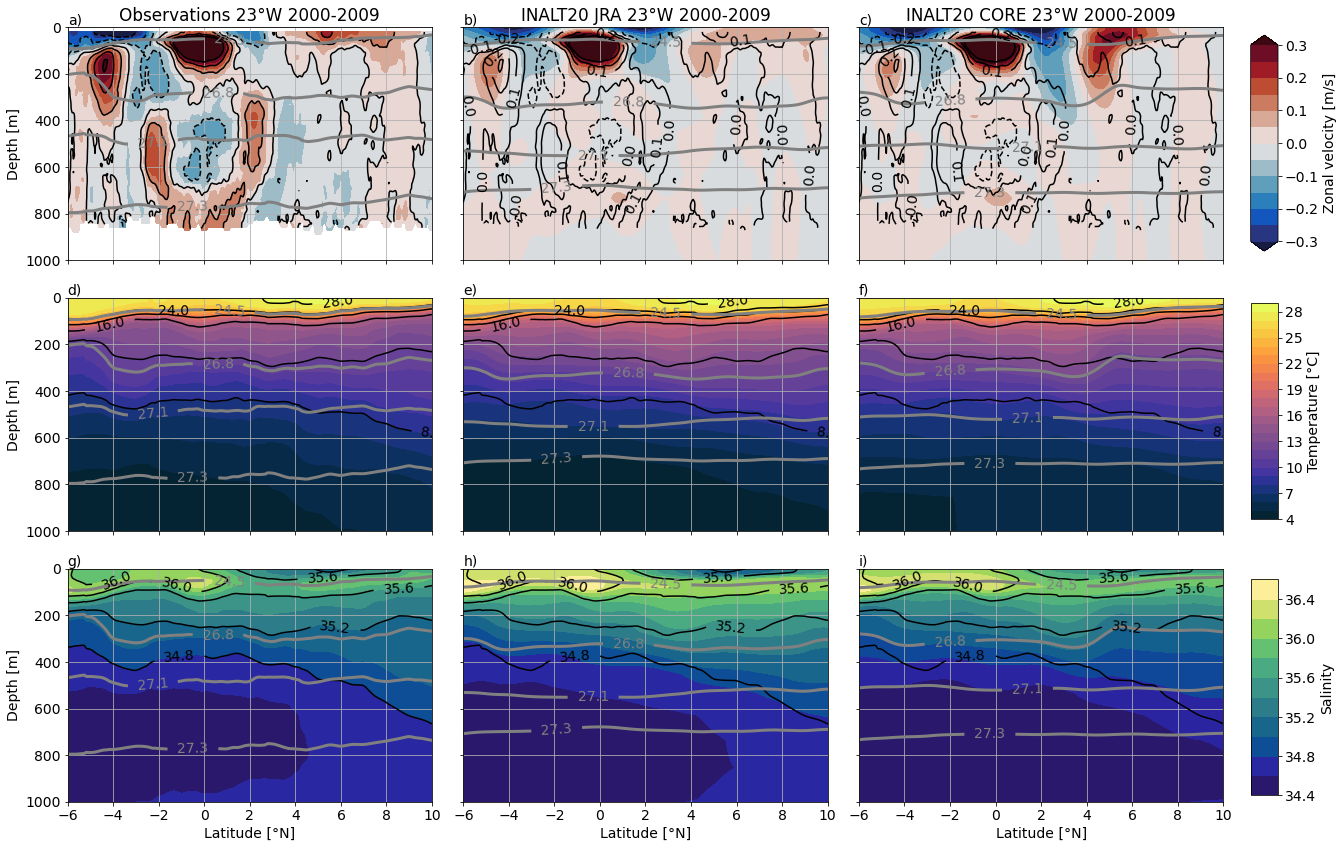

In [37]:


with xr.set_options(keep_attrs=True):
    JRA_ucur_mean = box_JRA.sel(time_counter=slice(*tlim_jra)
                               ).mean(['time_counter','lon'])
    CORE_ucur_mean = box_CORE.sel(time_counter=slice(*tlim_core)
                                 ).mean(['time_counter','lon'])

fs = 14;
    
fig,axs = plt.subplots(3,3,figsize=[19,12],sharex=True,sharey=True)
JRA_ucur_mean.vozocrtx.plot.contourf(ax=axs[0,1],
                x='lat',y='depth',ylim=[1000,0],xlim=[-6,10],
                levels=np.arange(-.30,.35,.05),cmap=cmocean.cm.balance,
                add_colorbar=False)
p=(obs_23W_2021.u_mean).plot.contour(ax=axs[0,1],
                yincrease=False,levels=np.arange(-.3,.35,.1),colors='black')
plt.clabel(p,levels=np.arange(-.3,.3,.1),fmt='%3.1f',fontsize=fs)
p=JRA_ucur_mean.sigma_0m.plot.contour(ax=axs[0,1],
                    levels=[24.5, 26.8, 27.1, 27.3],colors='grey',
                    yincrease=False,linewidths=3)
plt.clabel(p,levels=[24.5, 26.8, 27.1, 27.3],fmt='%3.1f',fontsize=fs)
axs[0,1].set_title(f'INALT20 JRA 23°W {tlim_jra[0]}-{tlim_jra[1]}')

CORE_ucur_mean.vozocrtx.plot.contourf(ax=axs[0,2],
                x='lat',y='depth',ylim=[1000,0],
                levels=np.arange(-.30,.35,.05),cmap=cmocean.cm.balance,
                add_colorbar=False)
p=(obs_23W_2021.u_mean).plot.contour(ax=axs[0,2],
                yincrease=False,levels=np.arange(-.3,.35,.1),colors='black')
plt.clabel(p,levels=np.arange(-.3,.3,.1),fmt='%3.1f',fontsize=fs)
p=CORE_ucur_mean.sigma_0m.plot.contour(ax=axs[0,2],
                levels=[24.5, 26.8, 27.1, 27.3],colors='grey',yincrease=False,linewidths=3)
plt.clabel(p,levels=[24.5, 26.8, 27.1, 27.3],fmt='%3.1f',fontsize=fs)
axs[0,2].set_title(f'INALT20 CORE 23°W {tlim_core[0]}-{tlim_core[1]}')


imU = obs_23W_2021.u_mean.plot.contourf(ax=axs[0,0],yincrease=False,
                                  levels=np.arange(-.3,.35,.05),cmap=cmocean.cm.balance,
    add_colorbar=False)
obs_23W_2021.u_mean.plot.contour(ax=axs[0,0],yincrease=False,
                                 levels=np.arange(-.3,.35,.1),colors='black')
p=obs_23W_2021.s0_mean.plot.contour(ax=axs[0,0],
                                    levels=[24.5, 26.8, 27.1, 27.3],
                                    colors='grey',yincrease=False,linewidths=3)
plt.clabel(p,levels=[24.5, 26.8, 27.1, 27.3],fmt='%3.1f',fontsize=fs)
axs[0,0].set_title(f'Observations 23°W {tlim_jra[0]}-{tlim_jra[1]}')

## TEMPERATURE ###########################################################
temp_levs = np.arange(4,30,1)
temp_levs_obs = np.arange(4,30,4)
JRA_ucur_mean.votemper.plot.contourf(ax=axs[1,1],
                x='lat',y='depth',ylim=[1000,0],
                levels=temp_levs,cmap=cmocean.cm.thermal,
                add_colorbar=False)
p=(obs_23W_2021.t_mean).plot.contour(ax=axs[1,1],
                yincrease=False,levels=temp_levs_obs,colors='black')
plt.clabel(p,levels=temp_levs_obs,fmt='%3.1f',fontsize=fs)
p=JRA_ucur_mean.sigma_0m.plot.contour(ax=axs[1,1],
                    levels=[24.5, 26.8, 27.1, 27.3],colors='grey',
                    yincrease=False,linewidths=3)
plt.clabel(p,levels=[24.5, 26.8, 27.1, 27.3],fmt='%3.1f',fontsize=fs)

CORE_ucur_mean.votemper.plot.contourf(ax=axs[1,2],
                x='lat',y='depth',ylim=[1000,0],
                levels=temp_levs,cmap=cmocean.cm.thermal,
                add_colorbar=False)
p=(obs_23W_2021.t_mean).plot.contour(ax=axs[1,2],
                yincrease=False,levels=temp_levs_obs,colors='black')
plt.clabel(p,levels=temp_levs_obs,fmt='%3.1f',fontsize=fs)
p=CORE_ucur_mean.sigma_0m.plot.contour(ax=axs[1,2],
                levels=[24.5, 26.8, 27.1, 27.3],colors='grey',yincrease=False,linewidths=3)
plt.clabel(p,levels=[24.5, 26.8, 27.1, 27.3],fmt='%3.1f',fontsize=fs)



imT = obs_23W_2021.t_mean.plot.contourf(ax=axs[1,0],yincrease=False,
                                  levels=temp_levs,cmap=cmocean.cm.thermal,
    add_colorbar=False)
p=obs_23W_2021.t_mean.plot.contour(ax=axs[1,0],yincrease=False,
                                 levels=temp_levs_obs,colors='black')
plt.clabel(p,levels=temp_levs_obs,fmt='%3.1f',fontsize=fs)
p=obs_23W_2021.s0_mean.plot.contour(ax=axs[1,0],
                                    levels=[24.5, 26.8, 27.1, 27.3],
                                    colors='grey',yincrease=False,linewidths=3)
plt.clabel(p,levels=[24.5, 26.8, 27.1, 27.3],fmt='%3.1f',fontsize=fs)

## SALINITY ##############################################################################

temp_levs = np.arange(34.4,36.8,.2)
temp_levs_obs = np.arange(34.4,36.8,.4)
JRA_ucur_mean.vosaline.plot.contourf(ax=axs[2,1],
                x='lat',y='depth',ylim=[1000,0],
                levels=temp_levs,cmap=cmocean.cm.haline,
                add_colorbar=False)
p=(obs_23W_2021.s_mean).plot.contour(ax=axs[2,1],
                yincrease=False,levels=temp_levs_obs,colors='black')
plt.clabel(p,levels=temp_levs_obs,fmt='%3.1f',fontsize=fs)
p=JRA_ucur_mean.sigma_0m.plot.contour(ax=axs[2,1],
                    levels=[24.5, 26.8, 27.1, 27.3],colors='grey',
                    yincrease=False,linewidths=3)
plt.clabel(p,levels=[24.5, 26.8, 27.1, 27.3],fmt='%3.1f',fontsize=fs)

CORE_ucur_mean.vosaline.plot.contourf(ax=axs[2,2],
                x='lat',y='depth',ylim=[1000,0],
                levels=temp_levs,cmap=cmocean.cm.haline,
                add_colorbar=False)
p=(obs_23W_2021.s_mean).plot.contour(ax=axs[2,2],
                yincrease=False,levels=temp_levs_obs,colors='black')
plt.clabel(p,levels=temp_levs_obs,fmt='%3.1f',fontsize=fs)
p=CORE_ucur_mean.sigma_0m.plot.contour(ax=axs[2,2],
                levels=[24.5, 26.8, 27.1, 27.3],colors='grey',yincrease=False,linewidths=3)
plt.clabel(p,levels=[24.5, 26.8, 27.1, 27.3],fmt='%3.1f',fontsize=fs)



imS = obs_23W_2021.s_mean.plot.contourf(ax=axs[2,0],yincrease=False,
                                  levels=temp_levs,cmap=cmocean.cm.haline,
    add_colorbar=False)
p=obs_23W_2021.s_mean.plot.contour(ax=axs[2,0],yincrease=False,
                                 levels=temp_levs_obs,colors='black')
plt.clabel(p,levels=temp_levs_obs,fmt='%3.1f',fontsize=fs)
p=obs_23W_2021.s0_mean.plot.contour(ax=axs[2,0],
                                    levels=[24.5, 26.8, 27.1, 27.3],
                                    colors='grey',yincrease=False,linewidths=3)
plt.clabel(p,levels=[24.5, 26.8, 27.1, 27.3],fmt='%3.1f',fontsize=fs)

for i, label in enumerate(('a)', 'b)','c)','d)','e)','f)','g)','h)','i)')):
    axs.flat[i].text(0, 1., label, transform=axs.flat[i].transAxes,
      fontsize=fs, ha='left',va='bottom')
    axs.flat[i].grid()
    if i<6:
        axs.flat[i].set_xlabel('')

for i,ax in enumerate(axs[:,2]):
    ax.set_ylabel('')
for i,ax in enumerate(axs[:,1]):
    ax.set_ylabel('')

plt.tight_layout()
fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.92, 0.7, 0.02, 0.25])
cb =fig.colorbar(imU, cax=cbar_ax)
cb.set_label('Zonal velocity [m/s]')

cbar_ax = fig.add_axes([0.92, 0.39, 0.02, 0.25])
cb =fig.colorbar(imT, cax=cbar_ax)
cb.set_label('Temperature [°C]')
    
cbar_ax = fig.add_axes([0.92, 0.07, 0.02, 0.25])
cb =fig.colorbar(imS, cax=cbar_ax)
cb.set_label('Salinity')
    
plt.savefig((out_dir_fig / f"INALT20_obs_23w_all_CORE{tlim_core[0]}_{tlim_core[1]}_JRA{tlim_jra[0]}_{tlim_jra[1]}{fig_format}"),dpi=300)

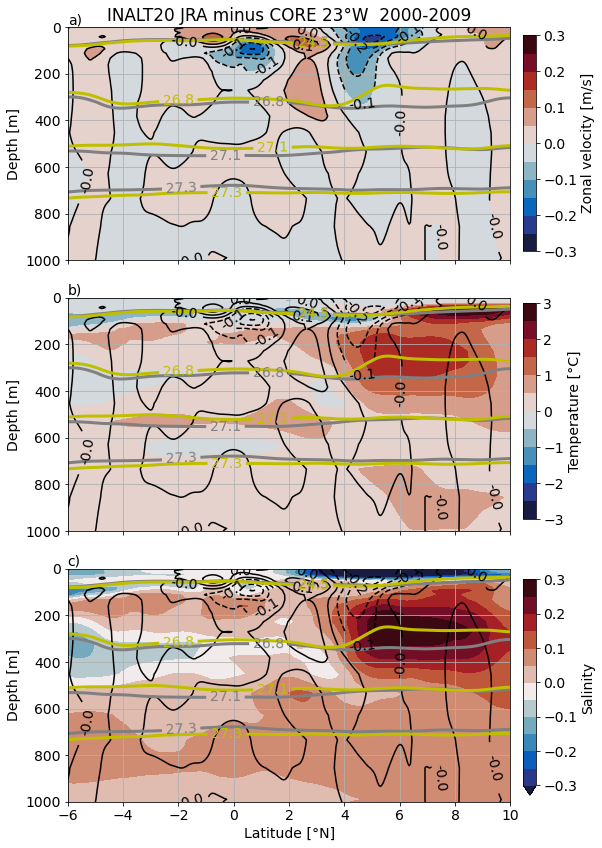

In [38]:
with xr.set_options(keep_attrs=True):
    JRA_ucur_mean = box_JRA.sel(time_counter=slice(*tlim_core)
                               ).mean(['time_counter','lon'])
    CORE_ucur_mean = box_CORE.sel(time_counter=slice(*tlim_core)
                                 ).mean(['time_counter','lon'])

fs = 14;
    
fig,axs = plt.subplots(3,1,figsize=[9,12],sharex=True,sharey=True)
imU = (JRA_ucur_mean.vozocrtx-CORE_ucur_mean.vozocrtx).plot.contourf(ax=axs[0],
                x='lat',y='depth',ylim=[1000,0],xlim=[-6,10],
                levels=np.arange(-.30,.35,.05),cmap=cmocean.cm.balance,
                add_colorbar=False)
p=(JRA_ucur_mean.vozocrtx-CORE_ucur_mean.vozocrtx).plot.contour(ax=axs[0],
                yincrease=False,levels=np.arange(-.30,.35,.05),colors='black')
plt.clabel(p,levels=np.arange(-.30,.35,.05),fmt='%3.1f',fontsize=fs)
p=JRA_ucur_mean.sigma_0m.plot.contour(ax=axs[0],
                    levels=[24.5, 26.8, 27.1, 27.3],colors='grey',
                    yincrease=False,linewidths=3)
plt.clabel(p,levels=[24.5, 26.8, 27.1, 27.3],fmt='%3.1f',fontsize=fs)
p=CORE_ucur_mean.sigma_0m.plot.contour(ax=axs[0],
                levels=[24.5, 26.8, 27.1, 27.3],colors='y',yincrease=False,linewidths=3)
plt.clabel(p,levels=[24.5, 26.8, 27.1, 27.3],fmt='%3.1f',fontsize=fs)
axs[0].set_title(f'INALT20 JRA minus CORE 23°W  {tlim_core[0]}-{tlim_core[1]}')

## TEMPERATURE ###########################################################
temp_levs = np.arange(4,30,1)
temp_levs_obs = np.arange(4,30,4)
imT = (JRA_ucur_mean.votemper-CORE_ucur_mean.votemper).plot.contourf(ax=axs[1],
                x='lat',y='depth',ylim=[1000,0],
                levels=np.linspace(-3, 3, 13),cmap=cmocean.cm.balance,
                add_colorbar=False)
p=(JRA_ucur_mean.vozocrtx-CORE_ucur_mean.vozocrtx).plot.contour(ax=axs[1],
                yincrease=False,levels=np.arange(-.30,.35,.05),colors='black')
plt.clabel(p,levels=np.arange(-.30,.35,.05),fmt='%3.1f',fontsize=fs)
p=JRA_ucur_mean.sigma_0m.plot.contour(ax=axs[1],
                    levels=[24.5, 26.8, 27.1, 27.3],colors='grey',
                    yincrease=False,linewidths=3)
plt.clabel(p,levels=[24.5, 26.8, 27.1, 27.3],fmt='%3.1f',fontsize=fs)
p=CORE_ucur_mean.sigma_0m.plot.contour(ax=axs[1],
                levels=[24.5, 26.8, 27.1, 27.3],colors='y',yincrease=False,linewidths=3)
plt.clabel(p,levels=[24.5, 26.8, 27.1, 27.3],fmt='%3.1f',fontsize=fs)

## SALINITY ##############################################################################

temp_levs = np.arange(34.4,36.8,.2)
temp_levs_obs = np.arange(34.4,36.8,.4)
imS = (JRA_ucur_mean.vosaline-CORE_ucur_mean.vosaline).plot.contourf(ax=axs[2],
                x='lat',y='depth',ylim=[1000,0],
                levels=np.linspace(-.3, .3, 13),cmap=cmocean.cm.balance,
                add_colorbar=False)
p=(JRA_ucur_mean.vozocrtx-CORE_ucur_mean.vozocrtx).plot.contour(ax=axs[2],
                yincrease=False,levels=np.arange(-.30,.35,.05),colors='black')
plt.clabel(p,levels=np.arange(-.30,.35,.05),fmt='%3.1f',fontsize=fs)
p=JRA_ucur_mean.sigma_0m.plot.contour(ax=axs[2],
                    levels=[24.5, 26.8, 27.1, 27.3],colors='grey',
                    yincrease=False,linewidths=3)
plt.clabel(p,levels=[24.5, 26.8, 27.1, 27.3],fmt='%3.1f',fontsize=fs)
p=CORE_ucur_mean.sigma_0m.plot.contour(ax=axs[2],
                levels=[24.5, 26.8, 27.1, 27.3],colors='y',yincrease=False,linewidths=3)
plt.clabel(p,levels=[24.5, 26.8, 27.1, 27.3],fmt='%3.1f',fontsize=fs)

for i, label in enumerate(('a)', 'b)','c)')):
    axs.flat[i].text(0, 1., label, transform=axs.flat[i].transAxes,
      fontsize=fs, ha='left',va='bottom')
    axs.flat[i].grid()
    if i<2:
        axs.flat[i].set_xlabel('')

plt.tight_layout()
fig.subplots_adjust(right=0.80)
cbar_ax = fig.add_axes([0.82, 0.7, 0.02, 0.25])
cb =fig.colorbar(imU, cax=cbar_ax)
cb.set_label('Zonal velocity [m/s]')

cbar_ax = fig.add_axes([0.82, 0.39, 0.02, 0.25])
cb =fig.colorbar(imT, cax=cbar_ax)
cb.set_label('Temperature [°C]')
    
cbar_ax = fig.add_axes([0.82, 0.07, 0.02, 0.25])
cb =fig.colorbar(imS, cax=cbar_ax)
cb.set_label('Salinity')
    
plt.savefig((out_dir_fig / f"INALT20_obs_23w_CORE_JRA_diff{fig_format}"),dpi=300)

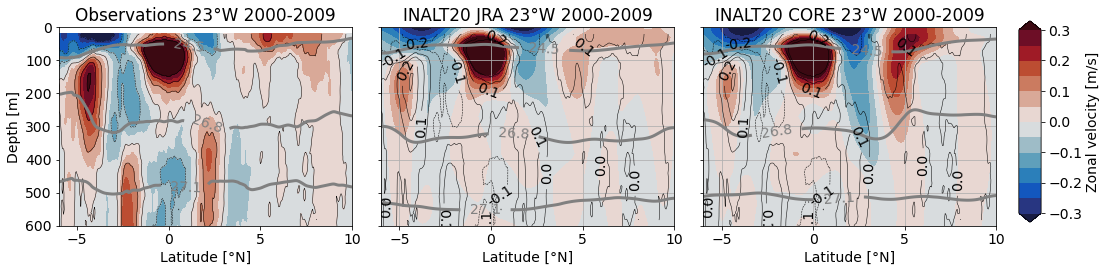

In [39]:
with xr.set_options(keep_attrs=True):
    JRA_ucur_mean = box_JRA.sel(time_counter=slice(*tlim_jra)
                               ).mean(['time_counter','lon'])
    CORE_ucur_mean = box_CORE.sel(time_counter=slice(*tlim_core)
                                 ).mean(['time_counter','lon'])

fs = 14;
    
fig,axs = plt.subplots(1,3,figsize=[15.5,4],sharex=True,sharey=True)
JRA_ucur_mean.vozocrtx.plot.contourf(ax=axs[1],
                x='lat',y='depth',ylim=[600,0],xlim=[-6,10],
                levels=np.arange(-.30,.35,.05),cmap=cmocean.cm.balance,
                add_colorbar=False)
p=(obs_23W_2021.u_mean).plot.contour(ax=axs[1],
                yincrease=False,levels=np.arange(-.3,.35,.1),colors='black',linewidths=.5)
plt.clabel(p,levels=np.arange(-.3,.3,.1),fmt='%3.1f',fontsize=fs)
p=JRA_ucur_mean.sigma_0m.plot.contour(ax=axs[1],
                    levels=[24.5, 26.8, 27.1, 27.3],colors='grey',
                    yincrease=False,linewidths=3)
plt.clabel(p,levels=[24.5, 26.8, 27.1, 27.3],fmt='%3.1f',fontsize=fs)
axs[1].set_title(f'INALT20 JRA 23°W {tlim_jra[0]}-{tlim_jra[1]}')

CORE_ucur_mean.vozocrtx.plot.contourf(ax=axs[2],
                x='lat',y='depth',ylim=[600,0],
                levels=np.arange(-.30,.35,.05),cmap=cmocean.cm.balance,
                add_colorbar=False)
p=(obs_23W_2021.u_mean).plot.contour(ax=axs[2],
                yincrease=False,levels=np.arange(-.3,.35,.1),colors='black',linewidths=.5)
plt.clabel(p,levels=np.arange(-.3,.3,.1),fmt='%3.1f',fontsize=fs)
p=CORE_ucur_mean.sigma_0m.plot.contour(ax=axs[2],
                levels=[24.5, 26.8, 27.1, 27.3],colors='grey',yincrease=False,linewidths=3)
plt.clabel(p,levels=[24.5, 26.8, 27.1, 27.3],fmt='%3.1f',fontsize=fs)
axs[2].set_title(f'INALT20 CORE 23°W {tlim_core[0]}-{tlim_core[1]}')


imU = obs_23W_2021.u_mean.plot.contourf(ax=axs[0],yincrease=False,
                                  levels=np.arange(-.3,.35,.05),cmap=cmocean.cm.balance,
    add_colorbar=False)
obs_23W_2021.u_mean.plot.contour(ax=axs[0],yincrease=False,
                                 levels=np.arange(-.3,.35,.1),colors='black',linewidths=.5)
p=obs_23W_2021.s0_mean.plot.contour(ax=axs[0],
                                    levels=[24.5, 26.8, 27.1, 27.3],
                                    colors='grey',yincrease=False,linewidths=3)
plt.clabel(p,levels=[24.5, 26.8, 27.1, 27.3],fmt='%3.1f',fontsize=fs)
axs[0].set_title(f'Observations 23°W {tlim_jra[0]}-{tlim_jra[1]}')

    
for i,ax in enumerate(axs[1:]):
    ax.set_ylabel('')
    ax.grid()


plt.tight_layout()
fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.7])
cb =fig.colorbar(imU, cax=cbar_ax)
cb.set_label('Zonal velocity [m/s]')

    
plt.savefig((out_dir_fig / f"INALT20_obs_23w_CORE{tlim_core[0]}_{tlim_core[1]}_JRA{tlim_jra[0]}_{tlim_jra[1]}_vel_u600m{fig_format}"),dpi=300)